# Aplicando o modelo treinado
Podemos aplicar o modelo treinado salvo para fazer previsões em "novos" dados. Nos exemplos abaixo, usei fotos da base que não foram usadas no treinamento do modelo para testar a rede neural.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from numpy.random import seed, randint

from keras.models import save_model, load_model
from keras.preprocessing.image import load_img


2023-12-23 02:06:18.507068: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 02:06:18.509313: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 02:06:18.539227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 02:06:18.539262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 02:06:18.540364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# diretório com as imagens
base_dir = 'base/utkface_aligned_cropped/crop_part1'

In [40]:
# coletando as imagens
image_paths = []
ages = []
genders = []
# gender_dict = {0:'Male', 1:'Female'}
gender_dict = {0:'Masculino', 1:'Feminino'}

# caso queira limitar o número de amostras (23708 disponíveis)
interval = 3000

for img_file in os.listdir(base_dir)[0:interval]:
    img_path = os.path.join(base_dir, img_file)
    aux = img_file.split('_')
    age = int(aux[0])
    gender = int(aux[1])

    image_paths.append(img_path)
    ages.append(age)
    genders.append(gender)

# transformando em dataframe
df = pd.DataFrame()

df['image'], df['age'], df['gender'] = image_paths, ages, genders
df = df[df['gender'] != 3]

### Análise da coleta

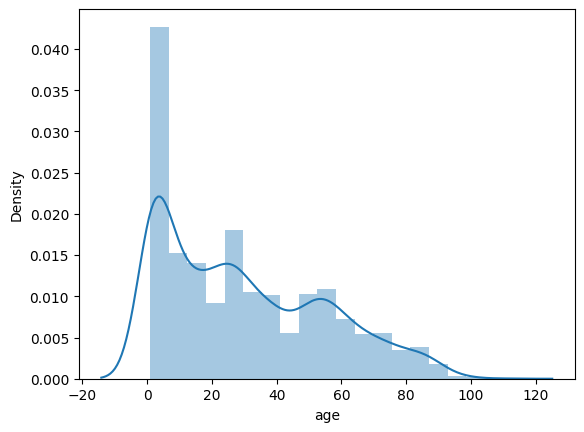

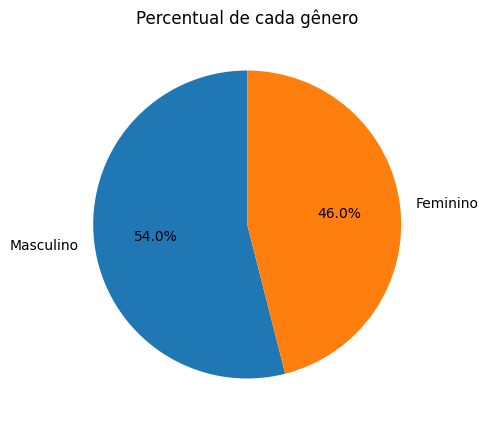

In [41]:
# distribuição de idades
sns.distplot(df['age'])

# conta a quantidade de cada gênero
gender_counts = df['gender'].value_counts()

# grafico de pizza pra quantidade de cada gênero
plt.figure(figsize=(15, 5))
# plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.pie(gender_counts, labels=["Masculino", "Feminino"], autopct='%1.1f%%', startangle=90)
plt.title('Percentual de cada gênero')
plt.show()

In [42]:
# função para extrair as features das imagens
# e redimensionar para 128x128 em escala de cinza
def extract_features(images):
    features = []
    for image in images:
        # transforma em escala de cinza
        # basta ignorar se quiser imagens coloridas
        img = load_img(image, grayscale=True) 
        img = img.resize((128, 128)) # redimensiona
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # basta ignorar se usar imagens coloridas
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [43]:
# testando nossa função
X = extract_features(df['image'])

X = X / 255.0 # normalizando os pixels de todas as imagens

In [44]:
# convertendo genero e idade para array
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# determinando o shape das imagens - conforme vimos anteriormente em X.shape
input_shape = (128, 128, 1)

# Carregando e usando o modelo salvo

In [45]:
loaded_model = load_model('modelo1.h5')

Gênero correto: Masculino  | Idade correta: 1
Gênero previsto: Masculino  | Idade prevista: 1
Gênero previsto corretamente idade prevista corretamente


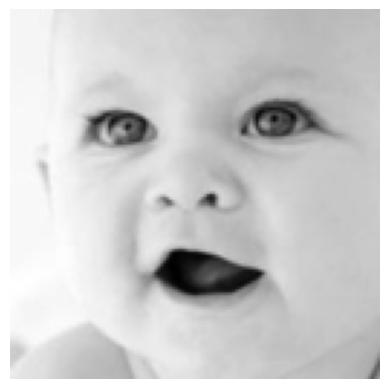

In [46]:
image_index = randint(0, len(X))
# print("Original Gender:", gender_dict[y_gender[image_index]], " | Original Age:", y_age[image_index])
print("Gênero correto:", gender_dict[y_gender[image_index]], " | Idade correta:", y_age[image_index])

margin = 5

# predição a partir do modelo
pred = loaded_model.predict(X[image_index].reshape(1, 128, 128, 1), verbose=0)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
# print("Predicted Gender:", pred_gender, " | Predicted Age:", pred_age)
print("Gênero previsto:", pred_gender, " | Idade prevista:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

if gender_dict[y_gender[image_index]] == pred_gender:
    # print("Gender predicted correctly", end=' ')
    print("Gênero previsto corretamente", end=' ')
else:
    # print("Gender not predicted correctly", end=' ')
    print("Gênero previsto incorretamente", end=' ')

age_interval = [pred_age-5, pred_age+5]
if y_age[image_index] in range(age_interval[0], age_interval[1]):
    # print("and age within expected interval!")
    print("idade prevista corretamente")
else:
    # print("but age outside of expected interval!")
    print("idade prevista incorretamente")

In [47]:
# verifica o resultado de n imagens aleatórias
def verify(num_imgs, img_array, age_margin=5):
    X_copy = img_array.copy()
    cor_gender = 0
    cor_age = 0
    indexes = np.random.choice(np.arange(0, num_imgs), num_imgs, replace=False)
    # print(indexes)
    for index in indexes:
        pred = loaded_model.predict(X_copy[index].reshape(1, 128, 128, 1), verbose=0)
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = round(pred[1][0][0])

        # verifica se o gênero foi previsto corretamente
        if pred_gender == gender_dict[y_gender[index]]:
            cor_gender += 1
        
        # verifica se a idade foi prevista corretamente
        if y_age[index] in range(pred_age-age_margin, pred_age+age_margin):
            cor_age += 1

    return cor_age, cor_gender

qnt_imgs = interval
cor_age, cor_gender = verify(qnt_imgs, X)

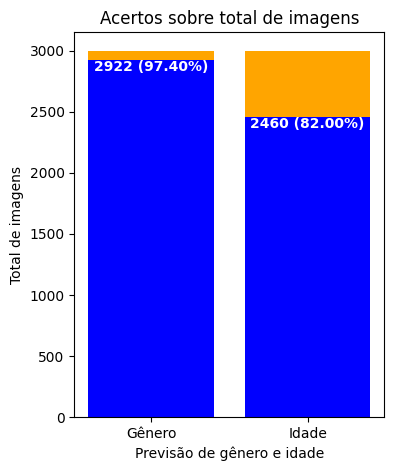

In [49]:
# grafico da quantidade de acertos de idade em relação ao total de imagens
x_axis = ["Gênero", "Idade"]
y1 = [qnt_imgs, qnt_imgs]
y2 = [cor_gender, cor_age]

fig, ax = plt.subplots(figsize=(4, 5))

# barras
bar_width = 0.8
bar1 = ax.bar(x_axis, y1, bar_width, color='orange', label='Total de imagens')
bar2 = ax.bar(x_axis, y2, bar_width, color='blue', label='Acertos')

# mostrando as porcentagens nas barras
for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, "", ha='center', va='bottom')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height} ({height / qnt_imgs * 100:.2f}%)', ha='center', va='top', fontdict={'color':'white', 'weight':'bold'})

plt.ylabel('Total de imagens')
plt.xlabel('Previsão de gênero e idade')
plt.title('Acertos sobre total de imagens')
plt.show()